# 1. Import dataframe and prepare dataset

In [1404]:
import pandas as pd
df_act=pd.read_csv("/Users/Aneta/Desktop/Final_Project_Aneta/ntcir12.csv", header=0, sep=",")

In [1405]:
#Clean dataframe and create a key-variable for future data merge. Use image_path to extract an unique ID
select=df_act[["image_path",'activity', 'day_of_week_name']]
select['path_id'] = select["image_path"].str.split('/').str.get(3)
select['path_id'] = select['path_id'].str[:33]
select=select.drop_duplicates(['path_id'], keep='last')
select.rename(columns={'activity': 'activity_new'}, inplace=True)
select=select.drop('image_path', axis=1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1406]:
#Open dataframe with additional activities that had been coded separately 
life_logs_csv = "/Users/Aneta/Desktop/Final_Project_Aneta/dataframe_lifelog.csv"
life_logs= pd.read_csv(life_logs_csv, sep=';', header=0, index_col=0)
lifelog_df=pd.merge(life_logs, select, on='path_id', how='outer')
lifelog_df.to_csv("lifelog_df_activity.csv", sep=";")

#Drop unnecessary columns keeping dataset clean
lifelog_df.drop(["day_id", "date", "minute_id", "image_directory", "image_id", "image_path", "image_time_x", 
                 "time", "day_of_week_name"], axis=1, inplace=True)
lifelog_df.head(3)

,user,location,activity,gender,age,height,weight,path_id,date_time,activity_new
0,u1,Home,NaN,male,40,173,78,NaN,NaN,NaN
1,u1,Home,NaN,male,40,173,78,NaN,NaN,NaN
2,u1,Home,NaN,male,40,173,78,NaN,NaN,NaN


Create additional variables related to time like: 1) only date, 2) the hour, 3)a time range, 4) a day of a week

In [1407]:
#Extract from datetime only dates to compare the user´s behaviour
lifelog_df["date_time"]=pd.to_datetime(lifelog_df["date_time"])
lifelog_df['date_just'] = lifelog_df['date_time'].dt.date

#Extract from datetime only time to analyse activities flow and daily schedule
lifelog_df['time_good'] = lifelog_df['date_time'].dt.time

#Extract from datetime only hours to compare the user´s behaviour 
lifelog_df['time_hour'] = lifelog_df["date_time"].apply(lambda x: x.hour)

#Group time of a day to a range like morning, afternoon, evening and night
lifelog_df["time_range"]=lifelog_df["time_hour"]
lifelog_df["time_range"].loc[(lifelog_df["time_range"] >= 6)& (lifelog_df["time_range"] <= 11)]=1
lifelog_df["time_range"].loc[(lifelog_df["time_range"] >= 12)& (lifelog_df["time_range"] <= 17)]=2
lifelog_df["time_range"].loc[(lifelog_df["time_range"] >= 18)& (lifelog_df["time_range"] <= 22)]=3
lifelog_df["time_range"].loc[(lifelog_df["time_range"] >= 23)& (lifelog_df["time_range"] <= 5)]=4
lifelog_df["time_range"].replace([1,2,3,4,], ["morning", "afternoon", "evening", "night"], inplace=True)

#Extract a day of a week to compare the user´s behaviour 
import calendar
lifelog_df['Month'] = lifelog_df['date_time'].dt.month.fillna(0).astype(int)
lifelog_df['Month'] = lifelog_df['Month'].apply(lambda x: calendar.month_abbr[x])
lifelog_df['day_of_week'] = lifelog_df['date_time'].dt.dayofweek
lifelog_df["day_of_week_name"]=lifelog_df['day_of_week']
lifelog_df["day_of_week_name"].replace([0,1,2,3,4,5,6], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], inplace=True)

In [1408]:
#The analysis will be conducted only on observations with assigned images. Other cases should be dropped
lifelog_df=lifelog_df.dropna(subset=['path_id'])



Save clean and prepared for analysis dataset

In [1409]:
lifelog_df.to_csv("clean_dataframe_activities.csv", sep=",")




# 2. Activities analysis 



# 2.1. Compare activities between the users

In [1413]:
#Extract from lifelogs dataframe needed variables
act_by_users=lifelog_df[["user","activity_new"]]
act_by_users=act_by_users.rename(columns = {"activity_new": "activity"})

#Calculate the frequencies of taken activities and normalize it to 0-100 scale.
act_by_users_tab=act_by_users.pivot_table(index='activity', columns='user', aggfunc=len, fill_value=0)
act_by_users=act_by_users.rename(columns = {"activity_new": "activities"})
act_by_users_tab1=act_by_users_tab.divide(act_by_users_tab.sum(axis=0), axis=1)* 100


In [1414]:
#Transfer a table to matrix and extract the arrays for data visualization 
act_by_users_tab1=act_by_users_tab1.as_matrix()
act_by_users_tab1=act_by_users_tab1.astype(int)

To visualiza the comparison between users and undertaken activities has been used a bubble chart from plotly librery. 
To use this visualization, first install Plotly's python package by using the package manager pip inside the terminal: sudo pip install plotly. After installing the Plotly package, set up the credentials. It can be fined here: 
https://plot.ly/settings/api

In [1415]:
#Insert your credetions. In free version of Plotly, you can run up 50 calls per day
import plotly 
plotly.tools.set_credentials_file(username='uribuku', api_key='3ZmoHkYQU2JtJ3IujqtZ')

In [1416]:
#Prepare a bubble chart using Plotly package

import plotly.plotly as py
import plotly.graph_objs as go

attend_seminary = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[1, 1, 1],
    text=act_by_users_tab1[0],
    mode='markers',
    name='Seminary',
    marker=dict(color = '2ED6B5', size=activities_u1[0], sizemode='area',))

biking = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[2, 2, 2],
    text=act_by_users_tab1[1],
    mode='markers',
    name='Biking',
    marker=dict(color="360C1F",size=activities_u1[1], sizemode='area',))

cleaning = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[3, 3, 3],
    text=act_by_users_tab1[2],
    mode='markers',
    name='Cleaning',
    marker=dict(color="A0ECDD",size=activities_u1[2], sizemode='area',))

cooking = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[4, 4, 4],
    text=act_by_users_tab1[3],
    mode='markers',
    name='Cooking',
    marker=dict(color="184B46", size=activities_u1[3], sizemode='area',))

driving = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[5, 5, 5],
    text=act_by_users_tab1[4],
    mode='markers',
    name='Driving',
    marker=dict(color="C16AAB",size=activities_u1[4], sizemode='area',))

drink_sb = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[6, 6, 6],
    text=act_by_users_tab1[5],
    mode='markers',
    name='Drinks with sb',
    marker=dict(color="EFEC34",size=activities_u1[5], sizemode='area',))

meal_alone = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[7, 7, 7],
    text=act_by_users_tab1[6],
    mode='markers',
    name='Eating alone',
    marker=dict(color="1E8974",size=activities_u1[6], sizemode='area',))

meal_sb = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[8, 8, 8],
    text=act_by_users_tab1[7],
    mode='markers',
    name='Meal with sb',
    marker=dict(color="0AFF2A",size=activities_u1[7], sizemode='area',))

meeting = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[9, 9, 9],
    text=act_by_users_tab1[8],
    mode='markers',
    name='Meeting',
    marker=dict(color="D1F907",size=activities_u1[8], sizemode='area',))

mobile = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[10, 10, 10,10,10,10,10],
    text=act_by_users_tab1[9],
    mode='markers',
    name='mobile',
    marker=dict(color="42CEC0",size=activities_u1[9], sizemode='area',))

plane = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[11, 11, 11],
    text=act_by_users_tab1[10],
    mode='markers',
    name='Plane',
    marker=dict(color="EEA1C3",size=activities_u1[10], sizemode='area',))

reading = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[12, 12, 12],
    text=act_by_users_tab1[11],
    mode='markers',
    name='Reading',
    marker=dict(color="B0EAFC",size=activities_u1[11], sizemode='area',))

resting = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[13, 13, 13],
    text=act_by_users_tab1[12],
    mode='markers',
    name='Resting',
    marker=dict(color="1DC0D6",size=activities_u1[12], sizemode='area',))

shopping = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[14, 14, 14],
    text=act_by_users_tab1[13],
    mode='markers',
    name='Shopping',
    marker=dict(color="B0EAFC",size=activities_u1[13], sizemode='area',))

socializing = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[15, 15, 15],
    text=act_by_users_tab1[14],
    mode='markers',
    name='Socializing',
    marker=dict(color="738804",size=activities_u1[14], sizemode='area',))

talking = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[16, 16, 16],
    text=act_by_users_tab1[15],
    mode='markers',
    name='Talking',
    marker=dict(color="3AD129",size=activities_u1[15], sizemode='area',))

transport = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[17, 17, 17],
    text=act_by_users_tab1[16],
    mode='markers',
    name='Transport',
    marker=dict(color="C52C71",size=activities_u1[16], sizemode='area',))

tv = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[18, 18, 18],
    text=act_by_users_tab1[17],
    mode='markers',
    name='Tv',
    marker=dict(color="42CEC0", size=activities_u1[17], sizemode='area',))

walking = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[19, 19, 19],
    text=act_by_users_tab1[18],
    mode='markers',
    name='Walking',
    marker=dict(color="A0245B", size=activities_u1[18], sizemode='area',))

working = go.Scatter(
    x=["User 1", "User 2", "User 3"],
    y=[20,20,20],
    text=act_by_users_tab1[19],
    mode='markers',
    name='Working',
    marker=dict(color="2ED6B5", size=activities_u1[19], sizemode='area',))

layout = go.Layout(
    title='Activities by users (in percentage)',
    xaxis=dict(
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=9,
        ticklen=2,
        gridwidth=10,
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        autotick=True,
        ticks='',
        showticklabels=False,
    ),
    paper_bgcolor='#FFFFFF',
    plot_bgcolor='#FFFFFF',
)

data1 = [attend_seminary,biking, cleaning, cooking, driving, drink_sb, meal_alone, meal_sb,
         meeting, mobile, plane, reading, resting, shopping, socializing, 
         talking, transport, tv, walking, working]
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig)

# 2.2. Analyse activities flow

The Lifelog datasets contains various interesting and valuable information on daily activities undertaken by the users. By extracting a date and time from the image´s paths, it was possible to identify when a singual activity had a place. Doing one step forward and looking at this dataset in total, appears that activities can be organized sequential. Therefore, it would be interesting to identify how users pass from one activity to the next one. However to conduct any analysis of the activities´ flow, the data had to be processed.


In [1472]:
#Extract from cleaned Lifelog dataset needed variables. Because not all observations have assigned an activity, then
#the missing values have been replaced into category "Unknown" referring that 
#one of the activities has been undertaken but stays unidentified.
acts=lifelog_df[["user","date_just", 'activity_new', "path_id"]]
acts['activity_new']=acts['activity_new'].fillna("Unknown")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Define activities flow within day´s dataframes

To identify the change of an activity, the dataset needed to be processed correctly, that has been done in following steps:
1. The same activity could be undertaken more than one time and next to each other. Then, it was needed to identify the unique activities
2. The dataset contains various days. Therefore, it was important to analyse the activities flow within separate dates considering each of them as a closed, unique unit of observations.
3. To indetify the activities flow, the new variable was created called "activity_change_unique.

    


In [1473]:
import numpy as np


DFList = []
for group in acts.groupby(acts["date_just"]):
    DFList.append(group[1])
    
d=[]

for i in range(len(DFList)):
    acts1=DFList[i]
    val=[]
    data=acts1["activity_new"].values
    for item in range(len(data)):
        if item == 0:
            val.append(1)
        else:
            if data[item]==data[item-1]:
                val.append(0)
            else:
                val.append(1)
        myarray = np.asarray(val)

    d.append(myarray)

unique_activities = []
for el in d:
    unique_activities.extend(el)

In [1474]:
#Add new variable to a dataset to identify when an activity is changed to the other.
acts['activity_change_unique'] = pd.Series(unique_activities, index=acts.index)
acts = acts.rename(columns={'activity_new': 'activity_new_old'})

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# 2.3. Visualize the activities flow

In [1475]:
#Select the user for whom you want to process the analysis
acts=acts[acts["user"] == "u3"]

In [1476]:
#Select from above prepared dataset, the unique activties that has been changed
acts_unique=acts[acts["activity_change_unique"] != 0]
acts_unique_list = acts_unique['activity_new_old'].tolist()

In [1477]:
#Process the data by assigningto the first activity, the second activity, to second activity - a third one.
#This dataframe structure will allow to identify how users were passing from one activity to other.
import numpy as np
unique_activity = []

for i in xrange(len(acts_unique_list) - 1):
    ll=[]
    current_item, next_item = acts_unique_list[i], acts_unique_list[i + 1]
    ll.append(current_item)
    ll.append(next_item)
    myarray = np.asarray(ll)
    unique_activity.append(myarray)

pair_activity=pd.DataFrame(unique_activity)
pair_activity.columns=("first_activity", "next_activity")
pair_activity.head(3)

,first_activity,next_activity
0,Unknown,Unknown
1,Unknown,Unknown
2,Unknown,Unknown


In [1478]:
#Prepare a table with activities and their pairs. Cross the first activity with the next activity.
#Count the frequency for each pair.
activity_plot=pd.crosstab(pair_activity.first_activity, pair_activity.next_activity, margins=False)
activity_plot

next_activity,Unknown,cleaning and chores,cooking,driving,having drinks with somebody,having drinks\meal alone,having meal with somebody,mobile,plane,reading,resting,shopping,socializing,talking,transport,tv,walking,working
first_activity,,,,,,,,,,,,,,,,,,
Unknown,376,27,54,15,29,43,9,163,2,1,62,12,45,30,11,33,101,60
cleaning and chores,27,0,10,0,0,2,0,1,0,0,0,0,0,0,0,7,1,0
cooking,54,9,1,0,0,6,0,2,0,0,0,0,0,0,0,4,1,0
driving,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0
having drinks with somebody,30,0,0,0,1,1,0,0,0,0,0,0,2,0,0,0,3,0
having drinks\meal alone,43,6,0,0,1,1,3,1,0,0,4,1,2,1,0,1,2,0
having meal with somebody,7,0,0,0,0,3,3,1,0,0,2,0,5,0,0,0,1,0
mobile,159,2,2,1,0,2,3,27,0,0,21,1,0,0,8,5,34,3
plane,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1484]:
#Prepare data for visualization
# Keep in mind that "Biking" is only for user 2 and user 3, "Plane" does not appear in user 2
#In case of user 3 does not appear: 'Seminar', "Biking", 'Meeting',
matrix_a=activity_plot.as_matrix()
labels=("Unknown", 'Cleaning', 'Cooking',
       'Driving', 'Drinks with sb',
       'Eating alone', 'Meal with sb', 
       'Mobile', "Plane",'Reading', 'Resting', 'Shopping', 'Socializing',
       'Talking', 'Transport', 'Tv', 'Walking', 'Working')
cross_tab = pd.DataFrame(matrix_a, columns=labels)
new_col=["Unknown",'Cleaning', 'Cooking',
       'Driving', 'Drinks with sb',
       'Eating alone', 'Meal with sb', 
       'Mobile', "Plane", 'Reading', 'Resting', 'Shopping', 'Socializing',
       'Talking', 'Transport', 'Tv', 'Walking', 'Working']
l=pd.DataFrame(new_col, columns=["Activity"])
cross_unique_acts = pd.concat([l, cross_tab], axis=1)
cross_unique_acts

,Activity,Unknown,Cleaning,Cooking,Driving,Drinks with sb,Eating alone,Meal with sb,Mobile,Plane,Reading,Resting,Shopping,Socializing,Talking,Transport,Tv,Walking,Working
0,Unknown,376,27,54,15,29,43,9,163,2,1,62,12,45,30,11,33,101,60
1,Cleaning,27,0,10,0,0,2,0,1,0,0,0,0,0,0,0,7,1,0
2,Cooking,54,9,1,0,0,6,0,2,0,0,0,0,0,0,0,4,1,0
3,Driving,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0
4,Drinks with sb,30,0,0,0,1,1,0,0,0,0,0,0,2,0,0,0,3,0
5,Eating alone,43,6,0,0,1,1,3,1,0,0,4,1,2,1,0,1,2,0
6,Meal with sb,7,0,0,0,0,3,3,1,0,0,2,0,5,0,0,0,1,0
7,Mobile,159,2,2,1,0,2,3,27,0,0,21,1,0,0,8,5,34,3
8,Plane,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Reading,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [1482]:
#Count the percentage explaining which the first actity is moving next to
table1=activity_plot.divide(activity_plot.sum(axis=1), axis=0 )

To visualize the activities flow, it was used a chart called "Circle" from Lighting Python Package. The package can be installed by running: [sudo] pip install lightning-python from terminal.


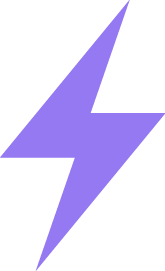

Connected to server at http://public.lightning-viz.org


<IPython.core.display.Javascript object>

In [1483]:
#Import Lighting library
from lightning import Lightning

from numpy import random, asarray
lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')

In [1487]:
#Create a chart of activity flow for each user. Keep in mind that user 1 does not have category "Biking"
#In user 2 does not appear "Plane"
table2=table1.as_matrix()
table2[table2<0.05] = 0
group1 = ([0,3,3,2,4,3,4,1,2, 5,5,3,4,1,2,5,6,7])

viz=lgn.circle(table2, 
               labels=[             
               "Unknown",'Cleaning', 'Cooking',
       'Driving', 'Drinks with sb',
       'Eating alone', 'Meal with sb', 
       'Mobile', "Plane", 'Reading', 'Resting', 'Shopping', 'Socializing',
       'Talking', 'Transport', 'Tv', 'Walking', 'Working'],
               group=[group1])
viz

In [1488]:
#See the chart in html
viz.open()

CREATE  SankeyWidget

In [1335]:
#The widget requires an edgelist with source, target and value columns
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

dfm=pd.melt(cross_unique_acts,id_vars=['Activity'], var_name='source', value_name='value')
dfm.columns=['target','source','value']
dfm['target']=dfm['target']
dfm.head(40)

,target,source,value
0,Unknown,Unknown,430
1,attending a seminar,Unknown,35
2,biking,Unknown,6
3,cleaning and chores,Unknown,174
4,cooking,Unknown,133
5,driving,Unknown,31
6,having drinks with somebody,Unknown,92
7,having drinks\meal alone,Unknown,157
8,having meal with somebody,Unknown,86
9,meeting,Unknown,207


In [1336]:
#The SankeyWidget function expects a list of dicts, each dict specifying an edge
#Also check how to drop rows where the weight is NA
links=dfm.dropna()[['source','target','value']].to_dict(orient='records')
links

[{'source': 'Unknown', 'target': 'Unknown', 'value': 430},
 {'source': 'Unknown', 'target': 'attending a seminar', 'value': 35},
 {'source': 'Unknown', 'target': 'biking', 'value': 6},
 {'source': 'Unknown', 'target': 'cleaning and chores', 'value': 174},
 {'source': 'Unknown', 'target': 'cooking', 'value': 133},
 {'source': 'Unknown', 'target': 'driving', 'value': 31},
 {'source': 'Unknown', 'target': 'having drinks with somebody', 'value': 92},
 {'source': 'Unknown', 'target': 'having drinks\\meal alone', 'value': 157},
 {'source': 'Unknown', 'target': 'having meal with somebody', 'value': 86},
 {'source': 'Unknown', 'target': 'meeting', 'value': 207},
 {'source': 'Unknown', 'target': 'mobile', 'value': 387},
 {'source': 'Unknown', 'target': 'plane', 'value': 10},
 {'source': 'Unknown', 'target': 'reading', 'value': 175},
 {'source': 'Unknown', 'target': 'resting', 'value': 171},
 {'source': 'Unknown', 'target': 'shopping', 'value': 74},
 {'source': 'Unknown', 'target': 'socializing'

In [34]:
layout = Layout(width="600", height="700")
k = SankeyWidget(links=links, margins=dict(top=-20, bottom=-50, left=100, right=100), layout=layout)
k

In [81]:
from IPython.display import (Image, SVG)
w.auto_save_png('test1.svg')

# 3. Identify the paterns in daily activity of the users

The identification of the paterns in daily activity of the users was a challenge. The questions was how to identify when an action starts and when finishes and at what time. This taskt requested multiple data processing in order to extract accurate, reliable and readible data. 
To identify how could look like a trivial/ casual day in the life of each user, we taken following steps:
1. Identify at what time an activity starts. We assumed that daily the same activity can be undertaken more than one time.
2. Identify at what time an activity ends. We assumed that daily the same activity can be undertaken more than one time. 
3. Identify how long a singual activity takes
4. Identify how often an activity is taken during a givin period
5. Identify how many times an activity is taken per a day and find its average 
6. Reduce the data to an average day and identify when and for how long an action is taken

### 3.1. Identify a start point of an activity

In [1546]:
#Extract from cleaned Lifelog dataset needed variables. Because not all observations have assigned an activity, then
#the missing values have been replaced into category "Unknown" referring that 
#one of the activities has been undertaken but stays unidentified.
acts=lifelog_df[["user","date_just", 'activity_new', "path_id"]]
acts['activity_new']=acts['activity_new'].fillna("Unknown")


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1547]:
#Identify the activities for which a start point will be processed
acts_start=acts
acts_start["activity_new"].unique()

array(['Unknown', 'mobile', 'cooking', 'having drinks\\meal alone', 'tv',
       'resting', 'walking', 'driving', 'socializing', 'reading',
       'talking', 'working', 'attending a seminar', 'shopping',
       'having meal with somebody', 'transport', 'cleaning and chores',
       'having drinks with somebody', 'meeting', 'plane', 'biking'], dtype=object)

In [1548]:
#Repeat an action for each of the activities for above variable
DFList = []
for group in acts_start.groupby(acts["date_just"]):
    DFList.append(group[1])
    
d=[]

for i in range(len(DFList)):
    acts1=DFList[i]
    val2=[]
    data=acts1["activity_new"].values
    for item in range(len(data)):
        if data[item-1] == "Unknown":
            val2.append(0)
        else:
            if data[item]=="Unknown":
                val2.append(1)
            else:
                val2.append(0)
    myarray = np.asarray(val2)

    d.append(myarray)

unique_activities_start = []
for el in d:
    unique_activities_start.extend(el)

In [1549]:
#Append a dataframe with start-variable per activity
acts_start["Unknown_start"] = pd.Series(unique_activities_start, index=acts_start.index)
acts_start.head(5)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,user,date_just,activity_new,path_id,Unknown_start
61388,u1,2015-02-23,Unknown,b00000000_21i6bq_20150223_070647e,1
61389,u1,2015-02-23,Unknown,b00000001_21i6bq_20150223_070808e,0
61390,u1,2015-02-23,Unknown,b00000002_21i6bq_20150223_070809e,0
61391,u1,2015-02-23,Unknown,b00000003_21i6bq_20150223_070810e,0
61392,u1,2015-02-23,Unknown,b00000004_21i6bq_20150223_070810e,0


In [1541]:
#Save the start of activities into csv
acts_start.to_csv("acts_start.csv", sep=",")

### 3.2. Identify a end point of an activity

In [1543]:
#Identify the activities for which a start point will be processed
acts_end=acts
acts_end["activity_new"].unique()

array(['Unknown', 'walking', 'mobile', 'working', 'talking', 'shopping',
       'meeting', 'having drinks\\meal alone', 'having meal with somebody',
       'cooking', 'reading', 'resting', 'attending a seminar', 'transport',
       'having drinks with somebody', 'cleaning and chores', 'biking',
       'socializing', 'tv', 'driving', 'plane'], dtype=object)

In [1544]:
#Repeat the process for each of the activities:
#Unknown', 'mobile', 'cooking', 'having drinks\\meal alone', 'tv','resting', 'walking', 'driving', 
#'socializing', 'reading','talking', 'working', 'attending a seminar', 'shopping',
#'having meal with somebody', 'transport', 'cleaning and chores','having drinks with somebody', 
#'meeting', 'plane', 'biking'

DFList_end = []
for group in acts_end.groupby(acts_end["date_just"]):
    DFList_end.append(group[1])
    
k=[]

for i in range(len(DFList_end)):
    acts1=DFList_end[i]
    val1=[]
    val1.append(1)
    data=acts1["activity_new"].values
    for item in range(len(data)-1):
        if data[item+1] !="Unknown" and data[item] == "Unknown":
            val1.append(1)
        else:
            val1.append(0)
    myarray = np.asarray(val1)

    k.append(myarray)


unique_activities_end= []
for el in k:
    unique_activities_end.extend(el)

In [1545]:
#Append a dataframe with end-variable per activity
acts_end['Unknown_end'] = pd.Series(unique_activities_end, index=acts_end.index)
acts_end.head(10)

,user,date_just,activity_new,path_id,Unknown_start,walking_start,mobile_start,working_start,talking_start,shopping_start,...,attend_seminar_start,transport_start,drinks_with_sb_start,cleaning_start,biking_start,socializing_start,tv_start,driving_start,plane_start,Unknown_end
98500,u2,2015-04-20,Unknown,b00002667_21i7lf_20150420_083832e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98501,u2,2015-04-20,Unknown,b00002668_21i7lf_20150420_083937e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98502,u2,2015-04-20,walking,b00002669_21i7lf_20150420_084014e,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98503,u2,2015-04-20,walking,b00002670_21i7lf_20150420_084050e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98504,u2,2015-04-20,Unknown,b00002671_21i7lf_20150420_084123e,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98505,u2,2015-04-20,Unknown,b00002672_21i7lf_20150420_084156e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98506,u2,2015-04-20,Unknown,b00002673_21i7lf_20150420_084230e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98507,u2,2015-04-20,Unknown,b00002674_21i7lf_20150420_084307e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98508,u2,2015-04-20,Unknown,b00002675_21i7lf_20150420_084341e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98509,u2,2015-04-20,Unknown,b00002676_21i7lf_20150420_084419e,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
#Save a dataframe into csv
acts_end.to_csv("acts_start_end1.csv", sep=",")

### 3.3. Relate the starting and ending time of a singular undertaken action

In [1904]:
#Read extracted previously dataset
df_acts_start_end=pd.read_csv("/Users/Aneta/Desktop/Final_Project_Aneta/acts_start_end.csv", sep=",")

In [1906]:
#Read time and path from main dataframe and create additional variable: time in seconds
time_date=lifelog_df[["time_good", "path_id"]]
time_date['time_hour'] = time_date["time_good"].apply(lambda x: x.hour)
time_date['time_minute'] = time_date["time_good"].apply(lambda x: x.minute)
time_date['time_second'] = time_date["time_good"].apply(lambda x: x.second)
time_date['time_seconds']=time_date['time_hour']*60*60+time_date['time_minute']*60+time_date['time_second']
time_seconds=time_date[["time_good", "path_id", "time_seconds"]]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [1907]:
#Merge time in seconds with starting and ending point
activity_start_end=pd.merge( time_seconds, df_acts_start_end, on='path_id', how='outer')

### 3.4. Count a duration of a signular action
Here, it will be counted a duration in a meaning of how long does take a singualar activity. Therefore, it requested to relate a time which a logger started an action and what time did he/she finish it. The analysis was conducted separatelly for each user.

In [1908]:
#Select a lifelogger/user
activities_s_e=activity_start_end[(activity_start_end['user'] == 'u3')]
activities_s_e["activity_new_old"].unique()
activities_s_e["unknown_start"].value_counts()

0    25732
1      851
Name: unknown_start, dtype: int64

In [1909]:
#Create a list of tags that you would like to explor in the next step
check_list=[
    ["unknown", activities_s_e, "Unknown", "unknown_start", "unknown_end"], 
["mobile", activities_s_e, "mobile", "mobile_start", "mobile_end"], 
["cooking", activities_s_e, "cooking", "cooking_start", "cooking_end"], 
["drinks_meal_alone", activities_s_e, "having drinks\meal alone", "drinks_meal_alone_start", "drinks_meal_alone_end"], 
["tv", activities_s_e, "tv", "tv_start", "tv_end"], 
["resting", activities_s_e, "resting", "resting_start", "resting_end"], 
["walking", activities_s_e, "walking", "walking_start", "walking_end"], 
["driving", activities_s_e, "driving", "driving_start", "driving_end"], 
["socializing", activities_s_e, "socializing", "socializing_start", "socializing_end"], 
["reading", activities_s_e, "reading", "reading_start", "reading_end"], 
["talking", activities_s_e, "talking", "talking_start", "talking_end"], 
["working", activities_s_e, "working", "working_start", "working_end"], 
["seminar", activities_s_e, "attending a seminar", "attend_seminar_start", "attend_seminar_end"], 
["shopping", activities_s_e, "shopping", "shopping_start", "shopping_end"], 
["meal_with_sb", activities_s_e, "having meal with somebody", "meal_w/sb_start", "meal_w/sb_end"], 
["transport", activities_s_e, "transport", "transport_start", "transport_end"], 
["cleaning", activities_s_e, "cleaning and chores", "cleaning_start", "cleaning_end"], 
["drinks_with_sb", activities_s_e, "having drinks with somebody", "drinks_w/sb_start", "drinks_w/sb_end"], 
["meeting", activities_s_e, "meeting", "meeting_start", "meeting_end"], 
["plane", activities_s_e, "plane", "plane_start", "plane_end"], 
["biking", activities_s_e, "biking", "biking_start", "biking_end"]]

In [1910]:
#Define a function to relate starting and ending point of a singular activity

import numpy as np

def create_dataset(name, df, tag, var1, var2):
    name=activities_s_e[["user","activity_new_old", "path_id", "date_just", "time_good", "time_seconds", 
                            var1, var2]]
    name=name[(name[var2]==1)|(name['activity_new_old'] == tag) & (name[var1] ==1) ]
    name=name.drop(name.index[0])

    name=name.reset_index()

    time_check=name["time_good"].tolist()
    unique_activity = []

    for i in xrange(len(time_check) - 1):
        ll=[]
        current_item, next_item = time_check[i], time_check[i + 1]
        ll.append(current_item)
        ll.append(next_item)
        myarray = np.asarray(ll)
        unique_activity.append(myarray)
    
    time_check_1=name["time_seconds"].tolist()
    unique_activity_1 = []

    for i in xrange(len(time_check_1) - 1):
        mm=[]
        current_item1, next_item1 = time_check_1[i], time_check_1[i + 1]
        mm.append(current_item1)
        mm.append(next_item1)
        myarray = np.asarray(mm)
        unique_activity_1.append(myarray)
    
    pair_activity=pd.DataFrame(unique_activity)
    pair_activity1=pd.DataFrame(unique_activity_1)
    pair_activity.columns=("start_time", "end_time")
    pair_activity1.columns=("start_time_a", "end_time_a")

    name=pd.concat([name, pair_activity,pair_activity1], axis=1)

    name=name[name["activity_new_old"] == tag]
    name.tail(5)
    
    return name

In [1911]:
#Execute the function and create a dataset of starting and ending time
l_l=[]
for name, df, tag, var1, var2 in check_list:
    x=create_dataset(name, df, tag, var1, var2)
    l_l.append(x)
    
df_list=[]
cols=("index", "user", "activity_new_old", "path_id", "date_just", "time_good", "time_seconds",
      "start", "end", "start_time", "end_time", "start_time_a", "end_time_a")

for i in range(21):
    l_l[i].columns=cols

unique_activity= pd.concat(l_l)
unique_activity.head(100)

,index,user,activity_new_old,path_id,date_just,time_good,time_seconds,start,end,start_time,end_time,start_time_a,end_time_a
0,61386,u3,Unknown,b00000018_21i79q_20150615_084940e,2015-06-15,08:49:04,31744,1,0,08:49:04,08:58:04,31744.0,32284.0
1,61401,u3,Unknown,b00000033_21i79q_20150615_085840e,2015-06-15,08:58:04,32284,0,1,08:58:04,08:59:02,32284.0,32342.0
2,61402,u3,Unknown,b00000034_21i79q_20150615_085920e,2015-06-15,08:59:02,32342,1,0,08:59:02,09:03:04,32342.0,32584.0
3,61409,u3,Unknown,b00000041_21i79q_20150615_090343e,2015-06-15,09:03:04,32584,0,1,09:03:04,09:14:01,32584.0,33241.0
4,61429,u3,Unknown,b00000061_21i79q_20150615_091415e,2015-06-15,09:14:01,33241,1,0,09:14:01,09:15:05,33241.0,33305.0
5,61432,u3,Unknown,b00000064_21i79q_20150615_091557e,2015-06-15,09:15:05,33305,0,1,09:15:05,09:31:04,33305.0,34264.0
6,61460,u3,Unknown,b00000092_21i79q_20150615_093148e,2015-06-15,09:31:04,34264,1,0,09:31:04,09:32:02,34264.0,34322.0
7,61461,u3,Unknown,b00000093_21i79q_20150615_093223e,2015-06-15,09:32:02,34322,0,1,09:32:02,09:37:02,34322.0,34622.0
8,61469,u3,Unknown,b00000101_21i79q_20150615_093721e,2015-06-15,09:37:02,34622,1,0,09:37:02,09:37:05,34622.0,34625.0
9,61470,u3,Unknown,b00000102_21i79q_20150615_093757e,2015-06-15,09:37:05,34625,0,1,09:37:05,09:48:00,34625.0,35280.0


### 3.5. Analyse the average time when a logger starts and finishes an action regarding its average duration within a singual day 

In this section, we conduct an analysis that allows us to identify an average, daily schedule of a lifelogger. The analysis was done within hourly time ranges to identify in the most accurate way the sequentions of the actions.
The analysis was done in following steps:
1. Calculate an average frequenct of how many time an actity was undertaken per day by a singular user
2. Count how often an activity is understaken by a user
3. Count an average duration of activity
4. Count an average time when an activity is undertaken

The average end of an activity was defined as an average duration of an action within hourly ranges and as an average for all observation dates. Then, on the daily schedule chart has been presented only activities that appears more then 5 times per hour during total observation term.

In [1912]:
#Convert a time in seconds to time format. Count the duration of a singual action. 
#Eliminate cases with duration 0
unique_activity['start_hour'] = pd.to_datetime(unique_activity['start_time'], format='%H:%M:%S').dt.hour
unique_activity['end_hour'] = pd.to_datetime(unique_activity['end_time'], format='%H:%M:%S').dt.hour
unique_activity["duration"]=unique_activity['end_time_a']-unique_activity["start_time_a"]
unique_activity=unique_activity[unique_activity["duration"]>=0]
unique_activity["activity_new_old"].value_counts()

Unknown                        909
mobile                         244
walking                        204
resting                         86
cooking                         73
working                         70
having drinks\meal alone        63
tv                              57
socializing                     50
transport                       43
talking                         36
having drinks with somebody     35
shopping                        35
driving                         21
having meal with somebody       16
reading                          4
plane                            3
Name: activity_new_old, dtype: int64

### 3.5.1. Calculate the average frequency of k-activy per hour per day

In [1917]:
#Create the labels for below dataframe. Remember to check the time ranges. 
#Various users started to register the logs at different times
l_freq_perday=["activities", "date_just"]
for x in range(0,24):
    i="freq_perday_"+str(x)
    l_freq_perday.append(i)

out=("freq_perday_3", "freq_perday_5")
for x in out:
    l_freq_perday.remove(x)


In [1918]:
freq_perday_df=pd.pivot_table(unique_activity,index=["activity_new_old", "date_just"], values=["start_time_a"],
               columns=["start_hour"],aggfunc=[np.size])
freq_perday_df.to_csv("freq_perday_df1.csv", sep=",")
freq_perday_df=pd.read_csv("freq_perday_df1.csv", sep=",", index_col=0, header=1)
freq_perday_df=freq_perday_df.drop(freq_perday_df.index[[0,1]])
freq_perday_df=freq_perday_df.reset_index()
freq_perday_df.columns=l_freq_perday

freq_perday_df.head(5)

,activities,date_just,freq_perday_0,freq_perday_1,freq_perday_2,freq_perday_4,freq_perday_6,freq_perday_7,freq_perday_8,freq_perday_9,...,freq_perday_14,freq_perday_15,freq_perday_16,freq_perday_17,freq_perday_18,freq_perday_19,freq_perday_20,freq_perday_21,freq_perday_22,freq_perday_23
0,Unknown,2015-06-15,NaN,NaN,NaN,NaN,NaN,NaN,3.0,9.0,...,6.0,3.0,21.0,16.0,21.0,2.0,NaN,NaN,NaN,NaN
1,Unknown,2015-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,11.0,1.0,10.0,1.0,1.0,6.0,NaN,NaN,NaN
2,Unknown,2015-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,1.0,NaN,5.0,NaN,NaN,1.0,NaN,NaN,NaN
3,Unknown,2015-06-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Unknown,2015-06-20,5.0,13.0,6.0,13.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1933]:
#Create the labels for below dataframe. Remember to check the time ranges. 
#Various users started to register the logs at different times
l_freq_perday1=["activities"]
for x in range(0,24):
    i="freq_perday_"+str(x)
    l_freq_perday1.append(i)

out=( "freq_perday_3", "freq_perday_5")
for x in out:
    l_freq_perday1.remove(x)


In [1934]:
#Prepare a dataframe with of average frequency of how often an action was undertaken
freq_perday_df=freq_perday_df.groupby(freq_perday_df["activities"], axis=0).mean()
freq_perday_df.to_csv("freq_perday_u1_1.csv", sep=",")
freq_perday_df=pd.read_csv("freq_perday_u1_1.csv", sep=",", index_col=0, header=0)
freq_perday_df=freq_perday_df.reset_index()
freq_perday_df.columns=l_freq_perday1
freq_perday_df.head(5)

,activities,freq_perday_0,freq_perday_1,freq_perday_2,freq_perday_4,freq_perday_6,freq_perday_7,freq_perday_8,freq_perday_9,freq_perday_10,...,freq_perday_14,freq_perday_15,freq_perday_16,freq_perday_17,freq_perday_18,freq_perday_19,freq_perday_20,freq_perday_21,freq_perday_22,freq_perday_23
0,Unknown,3.0,13.0,6.0,13.0,2.0,NaN,3.0,5.5,1.5,...,5.428571,4.850000,5.20,5.058824,4.000000,3.785714,4.533333,3.3,4.5,2.666667
1,cooking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,3.333333,2.333333,2.25,4.333333,2.666667,NaN,1.666667,1.0,NaN,NaN
2,driving,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,1.000000,1.00,2.000000,1.000000,2.500000,NaN,NaN,NaN,NaN
3,having drinks with somebody,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,4.666667,2.333333,2.50,1.000000,1.000000,1.000000,NaN,1.0,1.0,NaN
4,having drinks\meal alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.166667,1.666667,2.00,2.250000,2.000000,1.500000,2.000000,1.5,NaN,NaN


### Count the frequency of how many times an activity was undertaken
In this case, we identify which activities are the most frequent.

In [1935]:
#Create the labels for below dataframe. Remember to check the time ranges. 
#Various users started to register the logs at different times
l_start_size=["activities"]
for x in range(0,24):
    i="start_size_"+str(x)
    l_start_size.append(i)

out=( "start_size_3", "start_size_5")
for x in out:
    l_start_size.remove(x)


In [1936]:
#Count how often an activity was undertaken
start_size=pd.pivot_table(unique_activity, index=["activity_new_old"], values=["start_time_a"], columns=["start_hour"], aggfunc=[np.size])
start_size.to_csv("start_size1.csv", sep=",")
start_size=pd.read_csv("start_size1.csv", sep=",", index_col=0, header=1)
start_size=start_size.drop(start_size.index[[0,1]])
start_size=start_size.reset_index()
start_size.columns=l_start_size
start_size

,activities,start_size_0,start_size_1,start_size_2,start_size_4,start_size_6,start_size_7,start_size_8,start_size_9,start_size_10,...,start_size_14,start_size_15,start_size_16,start_size_17,start_size_18,start_size_19,start_size_20,start_size_21,start_size_22,start_size_23
0,Unknown,9.0,13.0,6.0,13.0,2.0,NaN,3.0,11.0,9.0,...,114.0,97.0,104.0,86.0,68.0,53.0,68.0,33.0,27.0,8.0
1,cooking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,10.0,14.0,9.0,13.0,8.0,NaN,5.0,1.0,NaN,NaN
2,driving,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,1.0,2.0,1.0,5.0,NaN,NaN,NaN,NaN
3,having drinks with somebody,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,14.0,7.0,5.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN
4,having drinks\meal alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,7.0,10.0,8.0,9.0,4.0,3.0,10.0,6.0,NaN,NaN
5,having meal with somebody,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,6.0,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN
6,mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,31.0,20.0,30.0,13.0,18.0,27.0,19.0,10.0,2.0,1.0
7,plane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN
8,reading,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,resting,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,9.0,5.0,10.0,9.0,10.0,6.0,6.0,6.0,3.0,NaN


### Count the average duration for an activity

In [1937]:
#Create the labels for below dataframe. Remember to check the time ranges. 
#Various users started to register the logs at different times
l_duration_avrg=["activities"]
for x in range(0,24):
    i="duration_avrg_"+str(x)
    l_duration_avrg.append(i)

out=( "duration_avrg_3",  "duration_avrg_5")
for x in out:
    l_duration_avrg.remove(x)

In [1938]:
#Count the average duration 
duration_avrg=pd.pivot_table(unique_activity,index=["activity_new_old"], values=["duration"],
               columns=["start_hour"],aggfunc=[np.mean])
duration_avrg.to_csv("duration_avrg.csv", sep=",")
duration_avrg=pd.read_csv("duration_avrg.csv", sep=",", index_col=0, header=1)
duration_avrg=duration_avrg.drop(duration_avrg.index[[0,1]])
duration_avrg=duration_avrg.reset_index()
duration_avrg.columns=l_duration_avrg
duration_avrg.head(5)

,activities,duration_avrg_0,duration_avrg_1,duration_avrg_2,duration_avrg_4,duration_avrg_6,duration_avrg_7,duration_avrg_8,duration_avrg_9,duration_avrg_10,...,duration_avrg_14,duration_avrg_15,duration_avrg_16,duration_avrg_17,duration_avrg_18,duration_avrg_19,duration_avrg_20,duration_avrg_21,duration_avrg_22,duration_avrg_23
0,Unknown,10139.666667,110.769231,179.833333,2192.307692,58.5,NaN,280.0,533.818182,420.0,...,405.105263,538.618557,410.086538,549.848837,539.088235,310.981132,373.426471,435.393939,200.333333,419.625
1,cooking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,363.000000,NaN,...,53.700000,84.714286,105.222222,83.230769,104.500000,NaN,95.600000,58.000000,NaN,NaN
2,driving,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121.666667,2102.000000,664.000000,1593.000000,3242.000000,757.200000,NaN,NaN,NaN,NaN
3,having drinks with somebody,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2942.000000,NaN,...,138.071429,506.285714,1920.400000,2222.000000,2163.000000,5882.000000,NaN,961.000000,1802.000000,NaN
4,having drinks\meal alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,301.000000,NaN,...,693.571429,244.500000,316.750000,241.111111,89.500000,139.000000,299.700000,559.333333,NaN,NaN


### Find which is an average time when a user starts an action.

In [1939]:
#Create the labels for below dataframe. Remember to check the time ranges. 
#Various users started to register the logs at different times
l_start_avrg=[]
for x in range(0,24):
    i="start_avrg_"+str(x)
    l_start_avrg.append(i)

out=("start_avrg_3", "start_avrg_5")
for x in out:
    l_start_avrg.remove(x)

In [1940]:
start_avrg=pd.pivot_table(unique_activity,index=["activity_new_old"], values=["start_time_a"],
               columns=["start_hour"],aggfunc=[np.mean])
start_avrg.to_csv("start_avrg.csv", sep=",")
start_avrg=pd.read_csv("start_avrg.csv", sep=",", index_col=0, header=1)
start_avrg=start_avrg.drop(start_avrg.index[[0,1]])
start_avrg.columns=l_start_avrg
start_avrg=start_avrg.reset_index()
start_avrg=start_avrg.rename(columns={"index": "activities"})

start_avrg.head(5)

,activities,start_avrg_0,start_avrg_1,start_avrg_2,start_avrg_4,start_avrg_6,start_avrg_7,start_avrg_8,start_avrg_9,start_avrg_10,...,start_avrg_14,start_avrg_15,start_avrg_16,start_avrg_17,start_avrg_18,start_avrg_19,start_avrg_20,start_avrg_21,start_avrg_22,start_avrg_23
0,Unknown,1902.555556,4714.923077,9142.666667,16963.769231,24511.5,NaN,32123.333333,34295.909091,38861.777778,...,52245.728070,55693.484536,59294.528846,62836.953488,66549.735294,70226.490566,73891.455882,77394.939394,81017.666667,83770.75
1,cooking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35220.000000,NaN,...,52052.800000,56124.285714,58836.444444,62910.384615,65920.500000,NaN,73526.600000,76384.000000,NaN,NaN
2,driving,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52981.666667,57423.000000,60120.000000,62431.500000,68341.000000,71629.600000,NaN,NaN,NaN,NaN
3,having drinks with somebody,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35942.000000,NaN,...,52365.142857,55244.857143,59750.400000,64622.000000,67260.000000,70741.000000,NaN,77164.000000,79502.000000,NaN
4,having drinks\meal alone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35583.000000,NaN,...,52520.142857,55538.800000,60076.750000,63221.333333,66768.750000,69224.000000,73905.100000,77093.000000,NaN,NaN


### Merge the dataframes in order to prepare the daily schedule visualization
To execute the used gantt chart, the dataframe needs to be transformed to requested dataframe structure having following columns: 
1. Activities
2. Activities average frequency per daily hour
3. The frequency in total of undertaken activities per hour
4. The average duration of an activity per hour
5. The time that an activity started within hourly ranges

To prepare the chart has been used: 1. The average starting time when an action starts, 2. The average ending time when an action finishes counted by sum of start in second and average duration multpilicated by an average frequency of undertaken activity per day and its hourly range


In [1941]:
#Melt the data to obtain needed dataframe structure
start_size_merge = pd.melt(start_size, id_vars=["activities"], var_name="Time_period", value_name="Val_start_size")
start_avrg_merge = pd.melt(start_avrg, id_vars=["activities"], var_name="Time_period", value_name="Val_start_hour")
duration_avrg_merge = pd.melt(duration_avrg, id_vars=["activities"], var_name="Time_period", value_name="Val_duration")
freq_perday_merge = pd.melt(freq_perday_df, id_vars=["activities"], var_name="Time_period", value_name="Val_frequency")

In [1948]:
#Merge above dataframes
average_time= pd.merge(start_size_merge, start_avrg_merge, how='outer', left_index=True, right_index=True)
average_time = pd.merge(average_time, duration_avrg_merge, how='outer', left_index=True, right_index=True)
average_time=average_time.rename(columns={"activities_x": "activities_good", "Time_period_x": "time_period"})
average_time.drop(["activities_y","Time_period_y", "activities", "Time_period"], axis=1, inplace=True)
average_time1 = pd.merge(average_time, freq_perday_merge, how='outer', left_index=True, right_index=True)
average_time1.drop(["activities","Time_period"], axis=1, inplace=True)
average_time1.to_csv("check.csv", sep=";")
average_time1.head(100)

,activities_good,time_period,Val_start_size,Val_start_hour,Val_duration,Val_frequency
0,Unknown,start_size_0,9.0,1902.555556,10139.666667,3.0
1,cooking,start_size_0,NaN,NaN,NaN,NaN
2,driving,start_size_0,NaN,NaN,NaN,NaN
3,having drinks with somebody,start_size_0,NaN,NaN,NaN,NaN
4,having drinks\meal alone,start_size_0,NaN,NaN,NaN,NaN
5,having meal with somebody,start_size_0,NaN,NaN,NaN,NaN
6,mobile,start_size_0,NaN,NaN,NaN,NaN
7,plane,start_size_0,NaN,NaN,NaN,NaN
8,reading,start_size_0,NaN,NaN,NaN,NaN
9,resting,start_size_0,2.0,662.000000,541.500000,2.0


In [1949]:
#Select only the activities that appears within selected hour more then 5 times
most_frequent_activities=average_time1[average_time1["Val_start_size"]>=5]

In [1950]:

most_frequent_activities=most_frequent_activities.fillna(0)

most_frequent_activities["action_start"] = pd.to_timedelta((most_frequent_activities["Val_start_hour"]).astype('int'), unit='s')
most_frequent_activities["duration_nomaliz"] = most_frequent_activities["Val_duration"] *most_frequent_activities["Val_frequency"]
most_frequent_activities["end_raw"] = most_frequent_activities["duration_nomaliz"] +most_frequent_activities["Val_start_hour"]
most_frequent_activities["action_end"] = pd.to_timedelta((most_frequent_activities["end_raw"]).astype('int'), unit='s')

most_frequent_activities=most_frequent_activities.sort_values(by=["activities_good",'Val_start_size'], ascending=[True, False])
most_frequent_activities.drop(["end_raw"], axis=1, inplace=True)
daily_activties_chart=most_frequent_activities[most_frequent_activities["activities_good"]!="Unknown"]
daily_activties_chart=daily_activties_chart[["activities_good", "action_start", "action_end"]]
daily_activties_chart['action_start']=daily_activties_chart['action_start'].astype(str).str[7:15]
daily_activties_chart['action_end']=daily_activties_chart['action_end'].astype(str).str[7:15]

daily_activties_chart


,activities_good,action_start,action_end
222,cooking,15:35:24,15:38:41
256,cooking,17:28:30,17:34:31
205,cooking,14:27:32,14:30:31
239,cooking,16:20:36,16:24:33
188,cooking,13:46:40,13:51:38
273,cooking,18:18:40,18:23:19
307,cooking,20:25:26,20:28:05
172,driving,12:29:15,13:37:08
291,driving,19:53:49,20:25:22
207,having drinks with somebody,14:32:45,14:43:29


In [1951]:
#Standarize the naming
daily_activties_chart["activities_good"].replace(['attending a seminar', "biking", "cleaning", 'cooking', 'driving',
       'having drinks with somebody', 'having drinks\\meal alone',
       'having meal with somebody', 'meeting', 'mobile', 'plane',
       'reading', 'resting',"socializing", 'shopping', 'talking', 'transport', 'tv',
       'walking', 'working'], 
        ["Seminar","Biking", "Cooking", "Cleaning", "Driving", "Drinks_wsb",
        "Eating_alone", "Meal_wsb", "Meeting", "Mobile", "Plane", "Reading",
        "Resting", "Socializing", "Shopping", "Talking", "Transport", "Tv", "Walking", "Working"], inplace=True)

In [1952]:
daily_activties_chart['action_category']=daily_activties_chart['activities_good']

In [1953]:
daily_activties_chart['action_category'].replace(
      ["Seminar", "Cooking", "Driving", "Drinks_wsb",
        "Eating_alone", "Meal_wsb", "Meeting", "Mobile", "Plane", "Reading",
        "Resting", "Shopping", "Talking", "Transport", "Tv", "Walking", "Working"],
    ["Education", "Domestic work/casual", "Transportation", "Social life",
    "Domestic work/casual", "Social life", "Communication", "Communication", "Transportation",
    "Leisure", "Leisure", "Domestic work/casual", "Communication", "Transportation", 
    "Leisure", "Walk", "Work"],  inplace=True)

In [1954]:
average_time1[average_time1["activities_good"]=="working"]

,activities_good,time_period,Val_start_size,Val_start_hour,Val_duration,Val_frequency
16,working,start_size_0,NaN,NaN,NaN,NaN
33,working,start_size_1,NaN,NaN,NaN,NaN
50,working,start_size_2,NaN,NaN,NaN,NaN
67,working,start_size_4,NaN,NaN,NaN,NaN
84,working,start_size_6,NaN,NaN,NaN,NaN
101,working,start_size_7,NaN,NaN,NaN,NaN
118,working,start_size_8,NaN,NaN,NaN,NaN
135,working,start_size_9,NaN,NaN,NaN,NaN
152,working,start_size_10,2.0,37893.000000,1651.500000,2.000000
169,working,start_size_11,7.0,41078.142857,289.142857,2.333333


In [1955]:
# Ajust value for working hours!!!!
list_chart=[]
for index, row in daily_activties_chart.iterrows():
    x="dict(Task='"+row["activities_good"]+"', Start='2017-01-01 "+row["action_start"]+"', Finish='2017-01-01 "+row["action_end"]+"', Activity='"+row["activities_good"]+"')"
    list_chart.append(x)
    
list_chart

["dict(Task='Cleaning', Start='2017-01-01 15:35:24', Finish='2017-01-01 15:38:41', Activity='Cleaning')",
 "dict(Task='Cleaning', Start='2017-01-01 17:28:30', Finish='2017-01-01 17:34:31', Activity='Cleaning')",
 "dict(Task='Cleaning', Start='2017-01-01 14:27:32', Finish='2017-01-01 14:30:31', Activity='Cleaning')",
 "dict(Task='Cleaning', Start='2017-01-01 16:20:36', Finish='2017-01-01 16:24:33', Activity='Cleaning')",
 "dict(Task='Cleaning', Start='2017-01-01 13:46:40', Finish='2017-01-01 13:51:38', Activity='Cleaning')",
 "dict(Task='Cleaning', Start='2017-01-01 18:18:40', Finish='2017-01-01 18:23:19', Activity='Cleaning')",
 "dict(Task='Cleaning', Start='2017-01-01 20:25:26', Finish='2017-01-01 20:28:05', Activity='Cleaning')",
 "dict(Task='Driving', Start='2017-01-01 12:29:15', Finish='2017-01-01 13:37:08', Activity='Driving')",
 "dict(Task='Driving', Start='2017-01-01 19:53:49', Finish='2017-01-01 20:25:22', Activity='Driving')",
 "dict(Task='Drinks_wsb', Start='2017-01-01 14:32:

In [1961]:
import plotly.plotly as py
import plotly.figure_factory as ff



df = [dict(Task='Cleaning', Start='2017-01-01 15:35:24', Finish='2017-01-01 15:38:41', Activity='Cleaning'),
 dict(Task='Cleaning', Start='2017-01-01 17:28:30', Finish='2017-01-01 17:34:31', Activity='Cleaning'),
 dict(Task='Cleaning', Start='2017-01-01 14:27:32', Finish='2017-01-01 14:30:31', Activity='Cleaning'),
 dict(Task='Cleaning', Start='2017-01-01 16:20:36', Finish='2017-01-01 16:24:33', Activity='Cleaning'),
 dict(Task='Cleaning', Start='2017-01-01 13:46:40', Finish='2017-01-01 13:51:38', Activity='Cleaning'),
 dict(Task='Cleaning', Start='2017-01-01 18:18:40', Finish='2017-01-01 18:23:19', Activity='Cleaning'),
 dict(Task='Cleaning', Start='2017-01-01 20:25:26', Finish='2017-01-01 20:28:05', Activity='Cleaning'),
 dict(Task='Driving', Start='2017-01-01 12:29:15', Finish='2017-01-01 13:37:08', Activity='Driving'),
 dict(Task='Driving', Start='2017-01-01 19:53:49', Finish='2017-01-01 20:25:22', Activity='Driving'),
 dict(Task='Drinks_wsb', Start='2017-01-01 14:32:45', Finish='2017-01-01 14:43:29', Activity='Drinks_wsb'),
 dict(Task='Drinks_wsb', Start='2017-01-01 15:20:44', Finish='2017-01-01 15:40:26', Activity='Drinks_wsb'),
 dict(Task='Drinks_wsb', Start='2017-01-01 16:35:50', Finish='2017-01-01 17:55:51', Activity='Drinks_wsb'),
 dict(Task='Eating_alone', Start='2017-01-01 15:25:38', Finish='2017-01-01 15:32:26', Activity='Eating_alone'),
 dict(Task='Eating_alone', Start='2017-01-01 20:31:45', Finish='2017-01-01 20:41:44', Activity='Eating_alone'),
 dict(Task='Eating_alone', Start='2017-01-01 17:33:41', Finish='2017-01-01 17:42:43', Activity='Eating_alone'),
 dict(Task='Eating_alone', Start='2017-01-01 16:41:16', Finish='2017-01-01 16:51:50', Activity='Eating_alone'),
 dict(Task='Eating_alone', Start='2017-01-01 14:35:20', Finish='2017-01-01 14:48:49', Activity='Eating_alone'),
 dict(Task='Eating_alone', Start='2017-01-01 21:24:53', Finish='2017-01-01 21:38:51', Activity='Eating_alone'),
 dict(Task='Meal_wsb', Start='2017-01-01 15:23:31', Finish='2017-01-01 15:31:38', Activity='Meal_wsb'),
 dict(Task='Meal_wsb', Start='2017-01-01 21:29:01', Finish='2017-01-01 21:37:57', Activity='Meal_wsb'),
 dict(Task='Mobile', Start='2017-01-01 13:35:40', Finish='2017-01-01 13:44:32', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 14:24:08', Finish='2017-01-01 14:41:29', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 16:32:30', Finish='2017-01-01 16:43:54', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 19:32:20', Finish='2017-01-01 19:46:14', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 12:32:46', Finish='2017-01-01 12:50:56', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 15:27:53', Finish='2017-01-01 15:36:01', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 20:28:55', Finish='2017-01-01 20:42:13', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 18:30:52', Finish='2017-01-01 18:47:12', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 17:28:16', Finish='2017-01-01 17:44:26', Activity='Mobile'),
 dict(Task='Mobile', Start='2017-01-01 21:21:21', Finish='2017-01-01 21:35:17', Activity='Mobile'),
 dict(Task='Resting', Start='2017-01-01 16:35:44', Finish='2017-01-01 17:05:23', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 18:31:21', Finish='2017-01-01 18:45:20', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 14:23:09', Finish='2017-01-01 14:49:39', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 17:26:22', Finish='2017-01-01 17:40:00', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 13:16:02', Finish='2017-01-01 13:32:17', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 10:36:11', Finish='2017-01-01 10:58:12', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 19:31:31', Finish='2017-01-01 19:49:04', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 20:17:52', Finish='2017-01-01 20:37:33', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 21:35:13', Finish='2017-01-01 21:44:47', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 12:35:38', Finish='2017-01-01 12:49:38', Activity='Resting'),
 dict(Task='Resting', Start='2017-01-01 15:41:26', Finish='2017-01-01 16:31:08', Activity='Resting'),
 dict(Task='Shopping', Start='2017-01-01 14:27:49', Finish='2017-01-01 14:40:49', Activity='Shopping'),
 dict(Task='Socializing', Start='2017-01-01 22:34:58', Finish='2017-01-01 23:01:49', Activity='Socializing'),
 dict(Task='Socializing', Start='2017-01-01 15:23:08', Finish='2017-01-01 16:00:07', Activity='Socializing'),
 dict(Task='Socializing', Start='2017-01-01 21:37:22', Finish='2017-01-01 21:48:23', Activity='Socializing'),
 dict(Task='Socializing', Start='2017-01-01 14:39:27', Finish='2017-01-01 14:52:26', Activity='Socializing'),
 dict(Task='Talking', Start='2017-01-01 13:28:19', Finish='2017-01-01 13:32:17', Activity='Talking'),
 dict(Task='Talking', Start='2017-01-01 16:22:02', Finish='2017-01-01 16:31:04', Activity='Talking'),
 dict(Task='Talking', Start='2017-01-01 14:14:50', Finish='2017-01-01 14:15:53', Activity='Talking'),
 dict(Task='Transport', Start='2017-01-01 14:26:36', Finish='2017-01-01 14:54:45', Activity='Transport'),
 dict(Task='Transport', Start='2017-01-01 13:33:39', Finish='2017-01-01 13:50:38', Activity='Transport'),
 dict(Task='Tv', Start='2017-01-01 15:35:22', Finish='2017-01-01 15:38:13', Activity='Tv'),
 dict(Task='Tv', Start='2017-01-01 17:22:48', Finish='2017-01-01 17:46:02', Activity='Tv'),
 dict(Task='Tv', Start='2017-01-01 14:22:19', Finish='2017-01-01 14:29:00', Activity='Tv'),
 dict(Task='Tv', Start='2017-01-01 16:27:19', Finish='2017-01-01 16:31:19', Activity='Tv'),
 dict(Task='Tv', Start='2017-01-01 20:36:03', Finish='2017-01-01 20:47:42', Activity='Tv'),
 dict(Task='Tv', Start='2017-01-01 21:26:53', Finish='2017-01-01 21:35:23', Activity='Tv'),
 dict(Task='Walking', Start='2017-01-01 14:26:29', Finish='2017-01-01 14:34:20', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 15:27:27', Finish='2017-01-01 15:41:17', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 13:26:20', Finish='2017-01-01 13:41:34', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 12:27:55', Finish='2017-01-01 12:41:11', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 16:27:11', Finish='2017-01-01 16:30:23', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 18:29:06', Finish='2017-01-01 18:54:40', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 17:41:28', Finish='2017-01-01 17:53:29', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 11:30:33', Finish='2017-01-01 11:38:44', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 20:23:17', Finish='2017-01-01 20:24:42', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 19:27:53', Finish='2017-01-01 19:43:38', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 22:24:03', Finish='2017-01-01 22:37:17', Activity='Walking'),
 dict(Task='Walking', Start='2017-01-01 21:32:21', Finish='2017-01-01 21:38:42', Activity='Walking'),
 dict(Task='Working', Start='2017-01-01 12:29:56', Finish='2017-01-01 16:48:14', Activity='Working'),
 dict(Task='Working', Start='2017-01-01 19:40:50', Finish='2017-01-01 19:50:47', Activity='Working')]

colors = dict(Seminar = '#C43B5B',
    Cleaning = '#92C9DC',
              Driving = '#118AB2',
              Drinks_wsb = '#FFD166',
              Eating_alone = '#92C9DC',
              Meal_wsb = '#FFD166',
              Mobile = '#ABD278',
              Resting = '#06D6A0',
              Socializing = '#FFD166',
              Shopping = '#92C9DC',
              Talking = '#BCE784',
              Transport = '#118AB2',
              Tv = '#06D6A0',
              Walking = '#F16889',
              Working = '#EF476F')


fig = ff.create_gantt(df, colors=colors, index_col='Activity', title='Daily Schedule',
                      show_colorbar=True, bar_width=0.8, showgrid_x=True, showgrid_y=True, group_tasks=True)
py.iplot(fig, filename='gantt-hours-minutes', world_readable=True)

# Define the average amoung of time that has been spent on activity 

In [1962]:

amount_time=pd.pivot_table(unique_activity,index=["activity_new_old"], values=["duration"],aggfunc=[np.sum])
amount_time.to_csv("amount_time.csv", sep=",")
amount_time=pd.read_csv("amount_time.csv", sep=",", index_col=0, header=1)
amount_time["number_days"]=len(unique_activity["date_just"].unique())
amount_time=amount_time.drop(amount_time.index[[0]])
amount_time["duration_avrg"]=amount_time["duration"]/amount_time["number_days"]
amount_time=amount_time.reset_index()
amount_time=amount_time.rename(columns={"index": "activities"})
amount_time=amount_time[["activities", "duration_avrg"]]
amount_time=amount_time.groupby(amount_time["activities"], axis=0).sum()
amount_time=amount_time.reset_index()
amount_time["duration_avrg"]=amount_time["duration_avrg"].astype(int)

In [1963]:
amount_timex=amount_time.as_matrix()
amount_timex=pd.DataFrame(amount_timex)
amount_timex.columns=("activities", "duration_avrg")
amount_timex.loc[1]
amount_timex=amount_timex.drop(amount_timex.index[[0]])

In [1964]:
amount_timex["duration_avrg"]=amount_timex["duration_avrg"].astype(int)
amount_timex["duration_%"]=amount_timex["duration_avrg"]/amount_timex["duration_avrg"].sum()*100
amount_timex["duration_%"]=amount_timex["duration_%"].round(2)
amount_timex

,activities,duration_avrg,duration_%
1,cooking,245,1.50
2,driving,884,5.42
3,having drinks with somebody,1303,7.99
4,having drinks\meal alone,781,4.79
5,having meal with somebody,184,1.13
6,mobile,2814,17.25
7,plane,440,2.70
8,reading,11,0.07
9,resting,2341,14.35
10,shopping,344,2.11


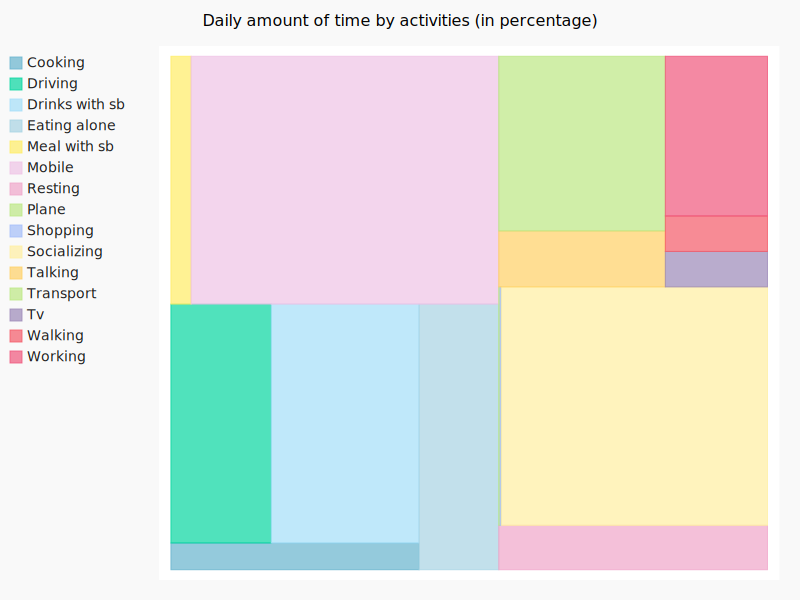

In [1966]:
from IPython.display import SVG
import pygal
from pygal.style import Style
custom_style = Style( 
    font_family="Helvetica Neue",
    value_colors=("#46494C"),
  transition='400ms ease-in',
  colors=("#67B4CE","#06D6A0","#A4DEF9",
"#A8D4E3","#ffed66","#EFC3E6",
"#F0A6CA","#BCE784","#A4BEF9","#FFEFA2","#FFD166","#BCE784","#9C89B8","#f45b69","#F0577C"))
      
treemap = pygal.Treemap(style=custom_style)
treemap.title = 'Daily amount of time by activities (in percentage)'
treemap.add('Cooking', amount_timex["duration_%"].loc[1])
treemap.add('Driving', amount_timex["duration_%"].loc[2])
treemap.add('Drinks with sb', amount_timex["duration_%"].loc[3])
treemap.add('Eating alone', amount_timex["duration_%"].loc[4])
treemap.add('Meal with sb', amount_timex["duration_%"].loc[5])
treemap.add('Mobile', amount_timex["duration_%"].loc[6])
treemap.add('Resting', amount_timex["duration_%"].loc[7])
treemap.add('Plane', amount_timex["duration_%"].loc[8])
treemap.add('Shopping', amount_timex["duration_%"].loc[8])
treemap.add('Socializing', amount_timex["duration_%"].loc[9])
treemap.add('Talking', amount_timex["duration_%"].loc[10])
treemap.add('Transport', amount_timex["duration_%"].loc[11])
treemap.add('Tv', amount_timex["duration_%"].loc[12])
treemap.add('Walking', amount_timex["duration_%"].loc[12])
treemap.add('Working', amount_timex["duration_%"].loc[14])
treemap.render_to_file('bar_chart.svg')


In [ ]:
SVG(filename='bar_chart.svg') 